# MNIST - Introduction

The MNIST is a large handwritten digit dataset commonly used to train various image processing systems. In this project I apply a few techniques to train a eficient machine learnin model, the goal is to apply techniques of dimensionality reduction and Bayesian Optimization for quicker hyperparameter tuning.

___

## Data Understanding

In [232]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [233]:
#this func gets a file path, it will be very useful to browse directories
def get_file_path(file, dir_name):
    project_dir = os.path.dirname(os.path.dirname(os.path.abspath("-")))
    data_dir = os.path.join(project_dir, dir_name)
    file_path = os.path.join(data_dir, file)
    return file_path
    
file_path = get_file_path("train.csv", "original data")

In [234]:
df = pd.read_csv(file_path)
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [235]:
X = df.drop(["label"], axis = 1).values
y = df["label"].values

In [236]:
 X.shape, y.shape

((60000, 784), (60000,))

In [237]:
file_path = get_file_path("test.csv", "original data")
df_test = pd.read_csv(file_path)
df_test.shape

(10000, 785)

In [274]:
y_test = df_test["label"]
X_test = df_test.drop(["label"], axis = 1)
X_test.shape, y_test.shape

((10000, 784), (10000,))

Each feature of the dataset is a pixel, and there are 60000 instances.
Since they are images it is possible to visualize them. Let's see a exemple:

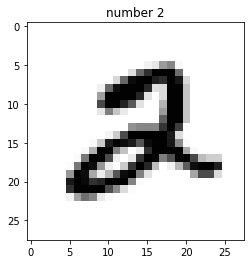

In [238]:
plt.imshow(X[5].reshape(28,28), cmap = mpl.cm.binary)
plt.title("number "+str(y[5]))
plt.show()

It was necessary to reshape X[3] to convert the array of pixels into a matrix so that it could be visualized.

## Data Preparation
First let's scale the data before peform a  Principal Component Analisys.

In [277]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(60000, 331)

Great!
With PCA it was possible to reduce  the number of features from 784 to 331 preserving 95% of the information(variance). Let's now start modeling.
___

## Modeling
I will now build a Pipeline with the data preparation steps.

Three algorithms are going to be used: KNN, LogisticRegression and RandomForestClassifier. 
They'll be validated using k-fold cross validation.

In [240]:
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from hyperopt import hp, tpe, STATUS_OK, Trials, fmin, space_eval

from functools import partial # to solve scoping problem when supplying more params' to objective function


First, let's train a baseline model to see how much we can improve the accuracy

In [276]:
#Baseline model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)
yhat = model.predict(X_test)
print("Accuracy = ",accuracy_score(y_test, yhat))

Accuracy =  0.2369


Now let's define the functions that are going to be used for hyper parameter tuning with Hyperopt:

In [241]:
def objective(params, model ,X, y):
    model.set_params(**params)

    scores = cross_val_score(model,X,y,scoring='accuracy',cv=3, n_jobs=-1)
    print(' Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    loss = 1-np.mean(scores)
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

    
def include_None(i_range):
    res = list(i_range)
    res.append(None)
    return res

def find_best_params(space,X,y,model):
    # Trials object to track progress
    trials = Trials()

    # Optimize
    best = fmin(
        fn=partial(objective, model=model, X=X, y=y),
        space=space,
        algo=tpe.suggest,
        max_evals=15,
        trials=trials
    )
    return best

In [242]:
#Data preparation PipeLine
prep_pipe = Pipeline(steps = [
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42))
    ]
)
X_prep = prep_pipe.fit_transform(X)

Finally, we define the space of hyper parameters and start the optmization. 
Three algorithms will be used:
 - RandomForestClassifier
 - KNeighborsClassifier
 - SVC

In [247]:
rf_space = {
    'n_estimators': hp.choice('n_estimators', range(50,2000)),
    'max_depth': hp.choice('max_depth', include_None(range(5,100,5))),
    'min_samples_split': hp.choice('min_samples_split',range(2,10)),
    'min_samples_leaf': hp.choice('min_samples_leaf',range(2,15)),
    'max_features': hp.choice('max_features', include_None(range(1,20,2))),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', include_None(range(2,20,2)))
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_best = find_best_params(space=rf_space, X=X_prep,y=y,model = rf_model)

 Accuracy: 0.824 (0.006)                              
 Accuracy: 0.815 (0.006)                                                          
 Accuracy: 0.921 (0.003)                                                          
 Accuracy: 0.820 (0.006)                                                            
 Accuracy: 0.803 (0.006)                                                            
 Accuracy: 0.810 (0.006)                                                          
 Accuracy: 0.530 (0.008)                                                          
 Accuracy: 0.809 (0.005)                                                          
 Accuracy: 0.922 (0.003)                                                          
 Accuracy: 0.801 (0.005)                                                          
 Accuracy: 0.774 (0.008)                                                           
 Accuracy: 0.831 (0.005)                                                           
 Accuracy: 0.889 (0.001)  

In [249]:
knn_space = {
    "n_neighbors":hp.choice("n_neighbors",range(2,15)),
    'algorithm': hp.choice('algorithm',['auto', 'ball_tree', 'kd_tree']),
    'metric': hp.choice('metric', ['chebyshev', 'minkowski']),
    'p': hp.choice('p', [1, 2]),
}

knn_model = KNeighborsClassifier(n_jobs=-1)
knn_best = find_best_params(space=knn_space, X=X_prep,y=y,model = knn_model)

 Accuracy: 0.939 (0.001)                              
 Accuracy: 0.936 (0.001)                                                            
 Accuracy: 0.941 (0.002)                                                            
 Accuracy: 0.935 (0.001)                                                             
 Accuracy: 0.938 (0.001)                                                             
 Accuracy: 0.933 (0.002)                                                             
 Accuracy: 0.942 (0.002)                                                             
 Accuracy: 0.924 (0.001)                                                           
 Accuracy: 0.938 (0.001)                                                          
 Accuracy: 0.917 (0.002)                                                          
 Accuracy: 0.935 (0.002)                                                           
 Accuracy: 0.919 (0.002)                                                             
 Accuracy: 

In [250]:
svc_space = {
      'C': hp.uniform('C', 0.05, 2.5),
      'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']),
      'degree':hp.choice('degree',range(2,6)),
      'gamma':hp.choice('gamma',["scale", "auto"])
}

svc_model = SVC(random_state=42)
svc_best = find_best_params(space=svc_space, X=X_prep,y=y,model = svc_model)

 Accuracy: 0.928 (0.001)                              
 Accuracy: 0.971 (0.001)                                                          
 Accuracy: 0.927 (0.000)                                                           
 Accuracy: 0.955 (0.001)                                                           
 Accuracy: 0.934 (0.001)                                                           
 Accuracy: 0.941 (0.002)                                                           
 Accuracy: 0.872 (0.003)                                                           
 Accuracy: 0.972 (0.002)                                                           
 Accuracy: 0.885 (0.001)                                                           
 Accuracy: 0.783 (0.004)                                                           
 Accuracy: 0.964 (0.002)                                                            
 Accuracy: 0.784 (0.004)                                                            
 Accuracy: 0.794 (0.

In [257]:
rf_best_params = space_eval(rf_space, rf_best)
rf_best_params

{'max_depth': 50, 'max_features': 19, 'max_leaf_nodes': None, 'min_samples_leaf': 13, 'min_samples_split': 2, 'n_estimators': 209}


In [255]:
knn_best_params = space_eval(knn_space, knn_best)
knn_best_params

{'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 6, 'p': 2}

In [256]:
svc_best_params = space_eval(svc_space, svc_best)
svc_best_params

{'C': 1.422315575267455, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}

Now we train the models using the best hyper parameters and test them with the test data

In [265]:
rf_model = RandomForestClassifier(random_state=40, n_jobs=-1)
rf_model.set_params(**rf_best_params)
rf_model.fit(X_prep, y)

knn_model = KNeighborsClassifier(n_jobs=-1)
knn_model.set_params(**knn_best_params)
knn_model.fit(X_prep, y)

svc_model = SVC(random_state=40)
svc_model.set_params(**svc_best_params)
svc_model.fit(X_prep, y)



SVC(C=1.422315575267455, degree=2, gamma='auto', kernel='poly', random_state=40)

In [259]:
X_test_prep = prep_pipe.transform(X_test)

In [267]:
yhat = rf_model.predict(X_test_prep)
a = accuracy_score(y_test, yhat)
print("RandomForestClassifier, accuracy:", a)

yhat = knn_model.predict(X_test_prep)
a = accuracy_score(y_test, yhat)
print("KNeighborsClassifier, accuracy:", a)

yhat = svc_model.predict(X_test_prep)
a = accuracy_score(y_test, yhat)
print("SVC, accuracy:", a)

RandomForestClassifier, accuracy: 0.5491
KNeighborsClassifier, accuracy: 0.8013
SVC, accuracy: 0.3427


Great, we improved the acurracy using techniques to speed up the hole process of modeling.

That's it for now!